In [44]:
import sys
sys.path.append("../../XLEMOO")

In [162]:
from XLEMOO.LEMOO import EAParams, MLParams, LEMParams, LEMOO
from XLEMOO.fitness_indicators import naive_sum, must_sum_to_one, asf_wrapper, single_objective
from XLEMOO.tree_interpreter import instantiate_tree_rules, find_all_paths
from XLEMOO.problems import river_pollution_problem
from desdeo_emo.recombination import SBX_xover, BP_mutation
from desdeo_emo.selection import TournamentSelection
from desdeo_problem.testproblems import test_problem_builder
from desdeo_tools.scalarization.ASF import SimpleASF, GuessASF, StomASF, PointMethodASF
from desdeo_tools.utilities import hypervolume_indicator, epsilon_indicator_ndims, fast_non_dominated_sort_indices

from sklearn.tree import DecisionTreeClassifier
import sklearn.tree as tree
import matplotlib.pyplot as plt
import numpy as np
from imodels import C45TreeClassifier

In [163]:
def plot_mean_fitness(population, fitness_fun):
    fitnesses = np.squeeze([fitness_fun(p) for p in population])
    means = np.array([np.mean(fitness) for fitness in fitnesses])
    plt.plot(np.arange(means.shape[0]), means)
    
def plot_std_fitness(population, fitness_fun):
    fitness = np.squeeze([fitness_fun(p) for p in population])
    stds = np.std(fitness, axis=1)
    plt.plot(np.arange(stds.shape[0]), stds)
    
def plot_best_fitness(population, fitness_fun):
    fitnesses = [fitness_fun(p) for p in population]
    mins = np.array([np.min(fitness) for fitness in fitnesses])
    plt.plot(np.arange(mins.shape[0]), mins)

## Define problem

In [164]:
n_objectives = 2
n_variables = 5
# problem = test_problem_builder("DTLZ7", n_variables, n_objectives)
problem = river_pollution_problem()

## Setting model parameters

In [170]:
#nadir = np.ones(n_objectives)
#ideal = np.zeros(n_objectives)
ideal = np.array([-6.34, -3.44, -7.5, 0, 0])
nadir = np.array([-4.75, -2.85, -0.32, 9.70, 0.35])
ref_point = np.array([-5, -2.9, -5.0, 3, 0.2])
fitness_fun = asf_wrapper(GuessASF(nadir), {"reference_point": ref_point})

# fitness_fun = naive_sum

lem_params = LEMParams(
    n_total_iterations=100,
    n_ea_gen_per_iter=10,
    n_ml_gen_per_iter=1,
    use_ea=True,
    use_ml=True,
    fitness_indicator=fitness_fun,
    past_gens_to_consider=1
)

ea_params = EAParams(
    population_size=164,
    cross_over_op=SBX_xover(),
    mutation_op=BP_mutation(problem.get_variable_lower_bounds(), problem.get_variable_upper_bounds()),
    selection_op=TournamentSelection(None, tournament_size=4),
    population_init_design="LHSDesign"
)

# ml = DecisionTreeClassifier(random_state=0)
ml = DecisionTreeClassifier()
ml_params = MLParams(
    H_split=0.2,
    L_split=0.2,
    ml_model=ml,
    ml_fitness=fitness_fun
)

## Setup LEMOO model

In [171]:
lemoo = LEMOO(problem, lem_params, ea_params, ml_params)

In [172]:
lemoo.reset_population()
history = lemoo.run()

starting learning mode
Cherry pick results: EA: 125; ML: 39.
starting learning mode
Cherry pick results: EA: 137; ML: 27.
starting learning mode
Cherry pick results: EA: 132; ML: 32.
starting learning mode
Cherry pick results: EA: 129; ML: 35.
starting learning mode
Cherry pick results: EA: 136; ML: 28.
starting learning mode
Cherry pick results: EA: 128; ML: 36.
starting learning mode
Cherry pick results: EA: 133; ML: 31.
starting learning mode
Cherry pick results: EA: 132; ML: 32.
starting learning mode
Cherry pick results: EA: 131; ML: 33.
starting learning mode
Cherry pick results: EA: 132; ML: 32.
starting learning mode
Cherry pick results: EA: 126; ML: 38.
starting learning mode
Cherry pick results: EA: 133; ML: 31.
starting learning mode
Cherry pick results: EA: 130; ML: 34.
starting learning mode
Cherry pick results: EA: 129; ML: 35.
starting learning mode
Cherry pick results: EA: 134; ML: 30.
starting learning mode
Cherry pick results: EA: 134; ML: 30.
starting learning mode
C

In [173]:
objectives = np.array([p.objectives for p in history])

/tmp/ipykernel_260080/2125544493.py:1: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



/tmp/ipykernel_260080/1874680187.py:2: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



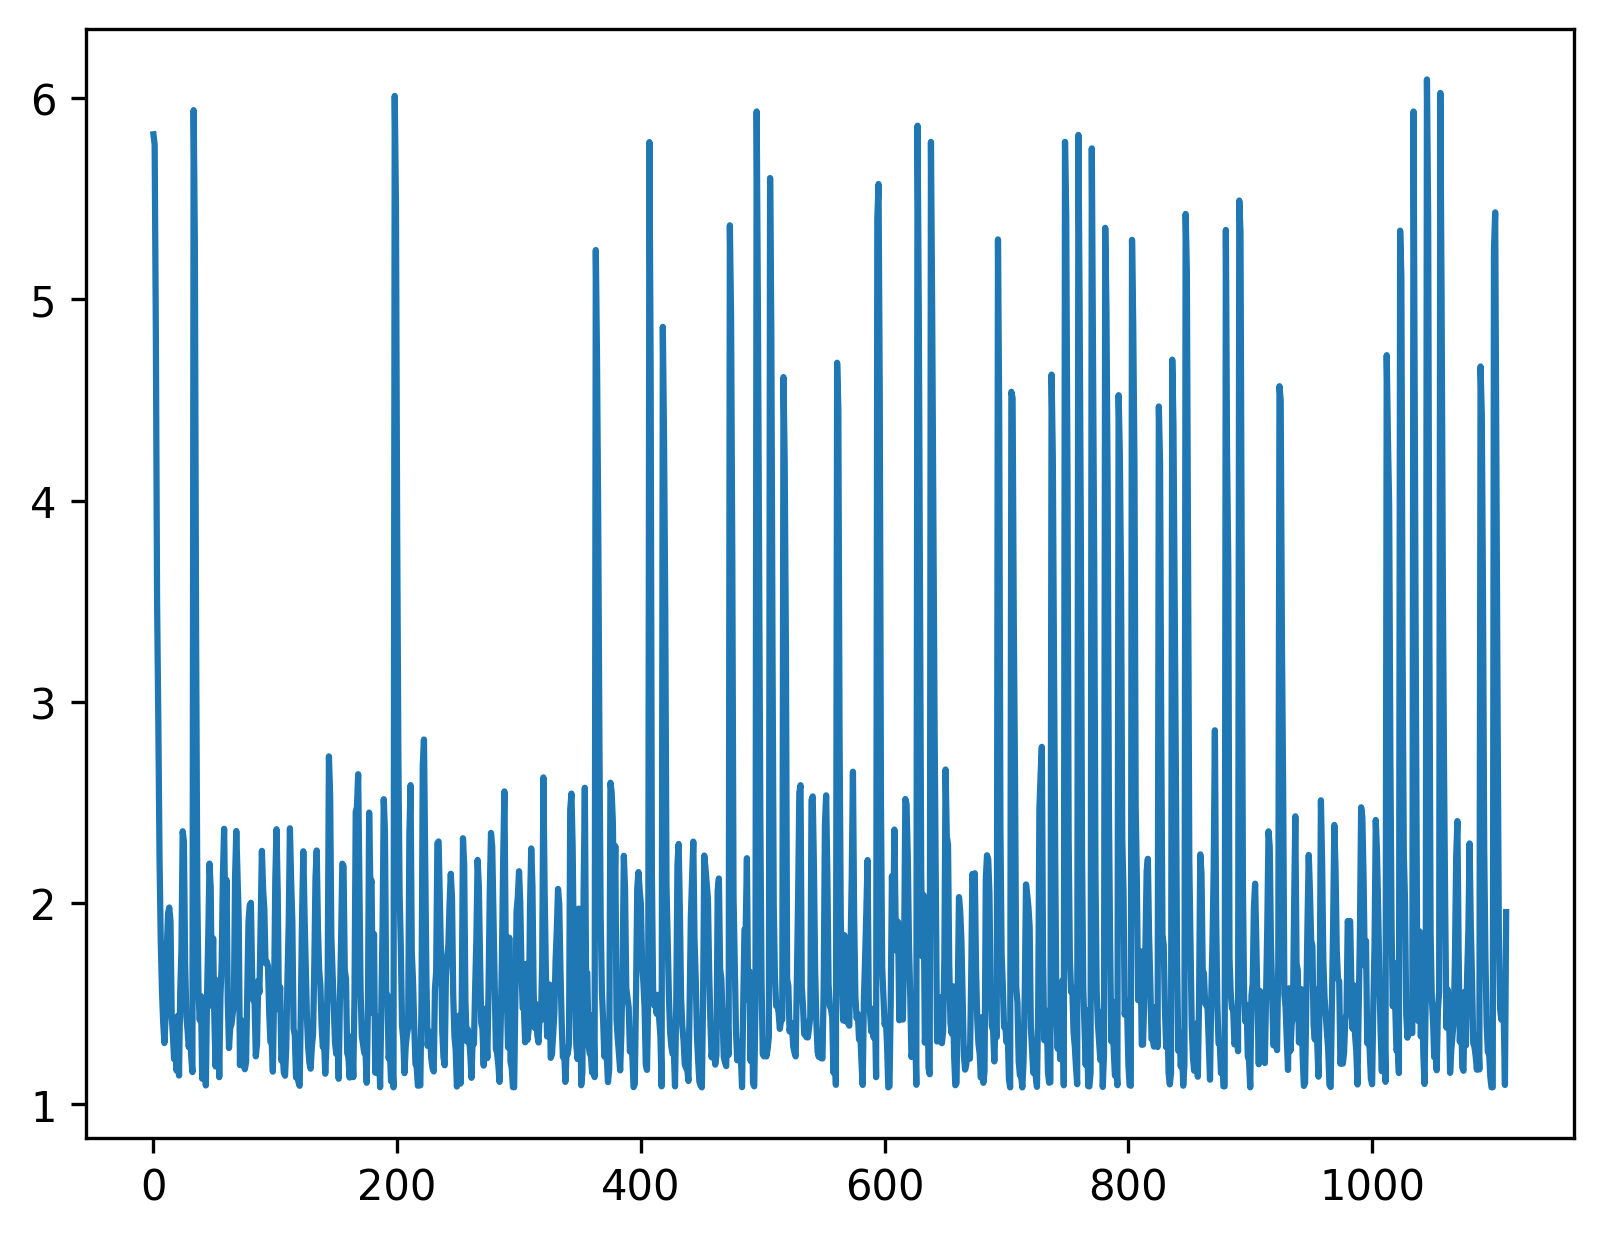

In [174]:
def plot_hypervolume(population, ref_point):
    objectives = np.array([p.problem.evaluate(p.individuals).objectives for p in population])
    hvs = np.array([hypervolume_indicator(objs, nadir) for objs in objectives])
    plt.plot(np.arange(hvs.shape[0]), hvs)
                       
plot_hypervolume(history, ref_point)

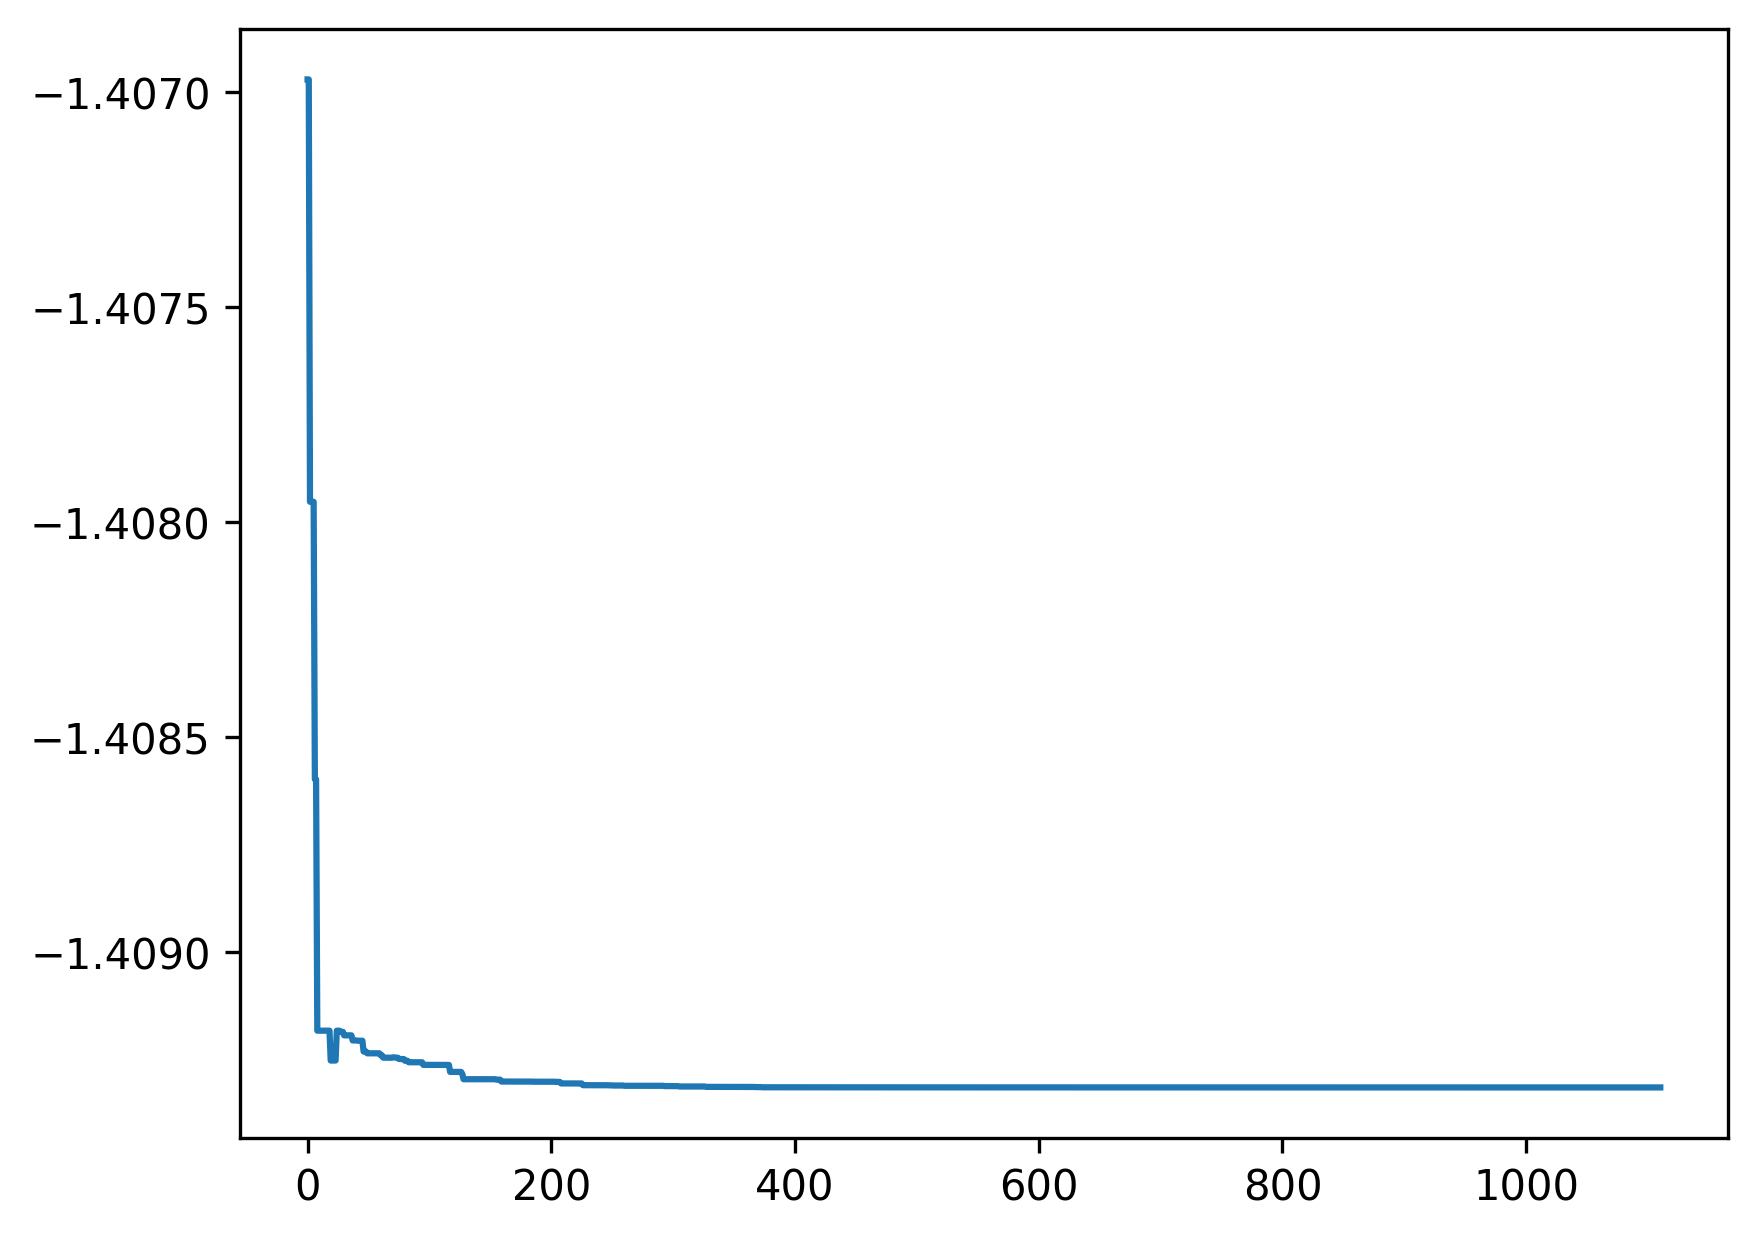

In [175]:
plot_best_fitness(history, fitness_fun)

/home/kilo/.cache/pypoetry/virtualenvs/xlemoo-6BFI3yUJ-py3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



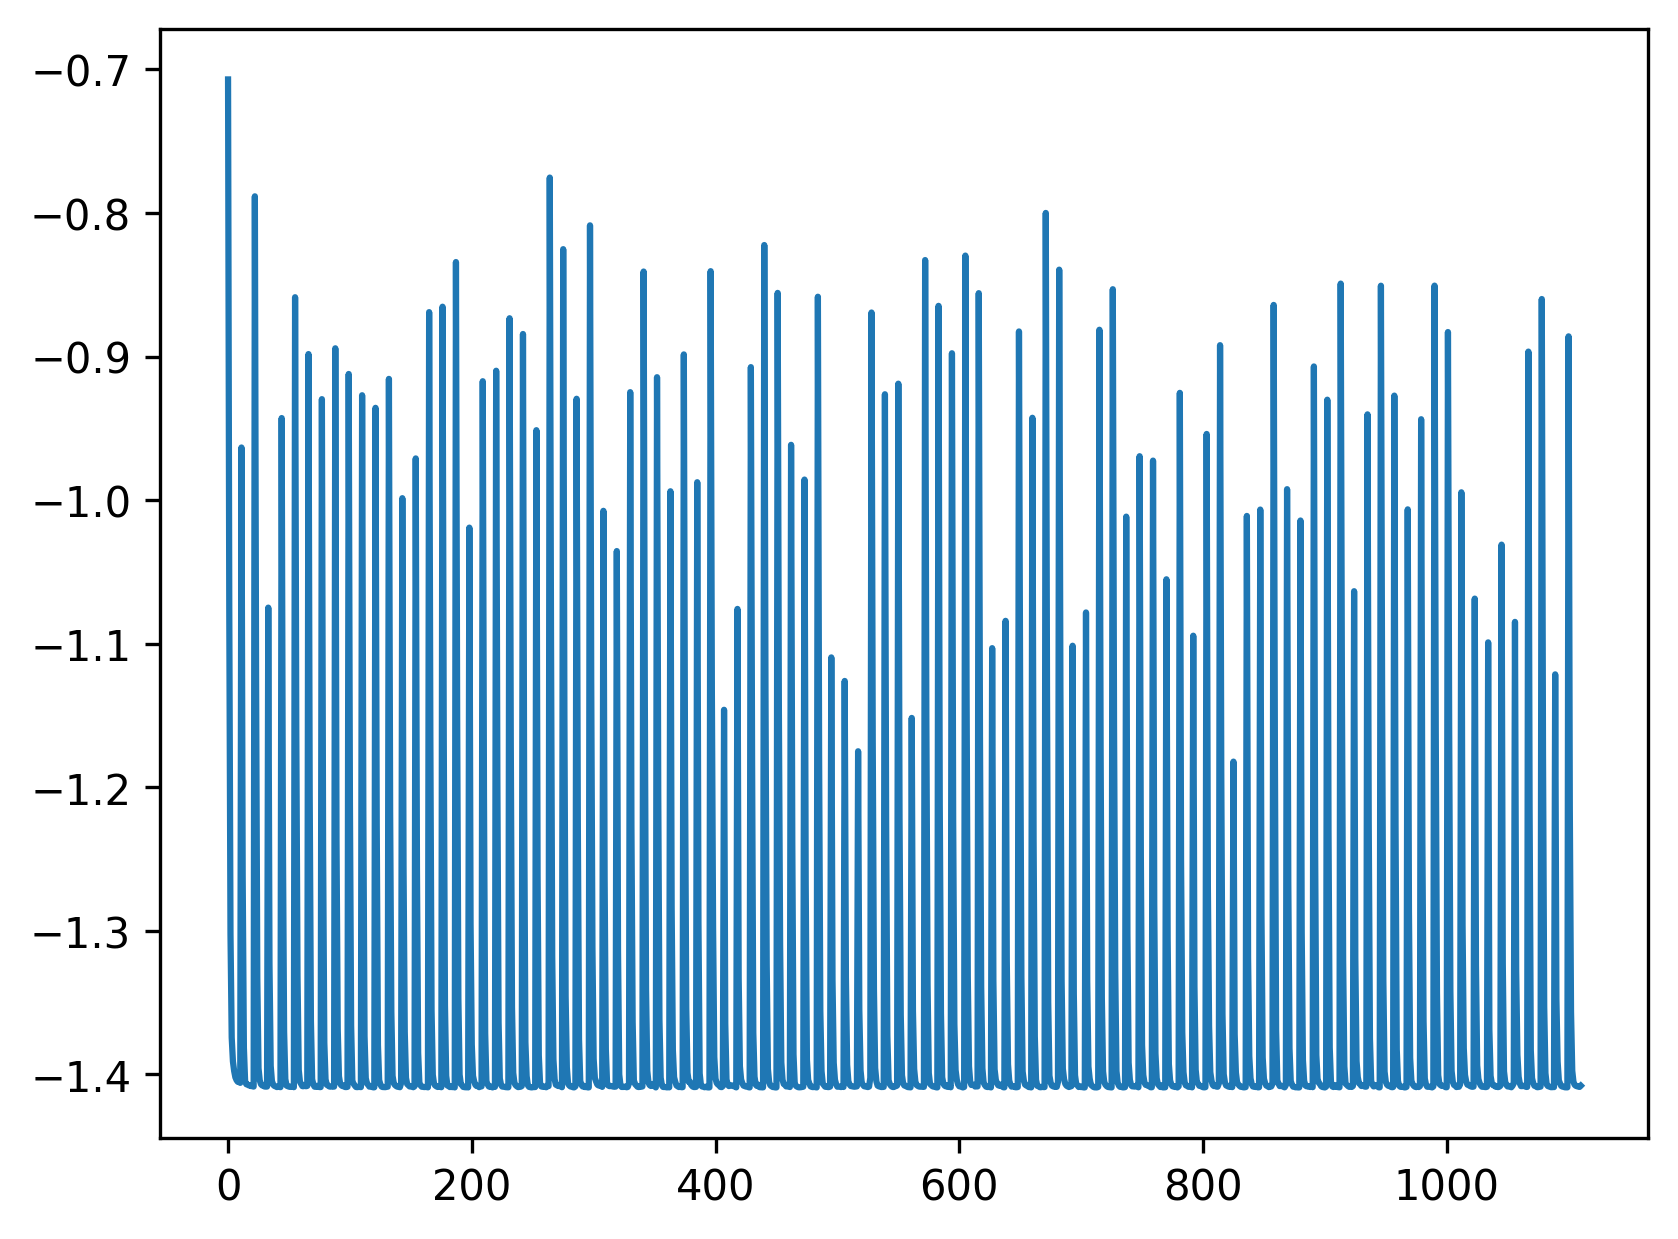

In [176]:
plot_mean_fitness(history, fitness_fun)

In [177]:
plot_std_fitness(history, fitness_fun)

AxisError: axis 1 is out of bounds for array of dimension 1

{'rules': [], 'samples': 12.0, 'impurity': 0.5, 'classification': -1}


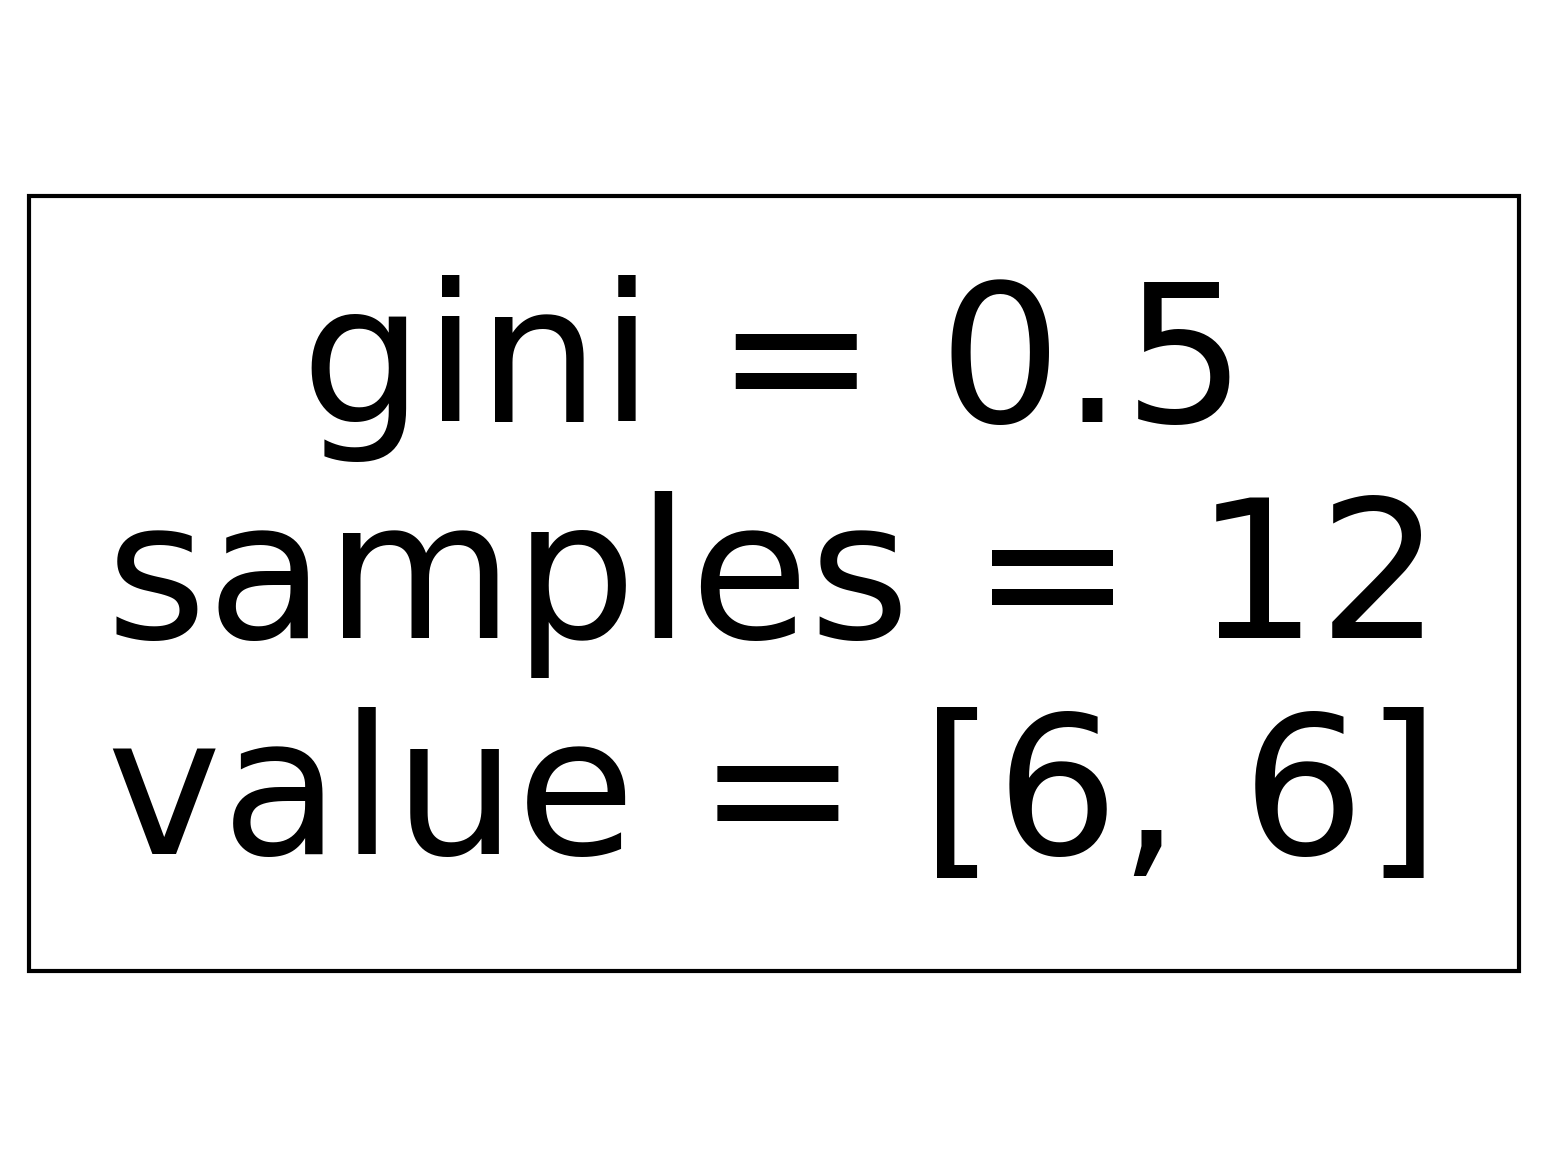

In [142]:
tree.plot_tree(lemoo.current_ml_model);
paths = find_all_paths(lemoo.current_ml_model)
for p in paths:
    print(p)

In [92]:
print(history[-1].individuals)

[[0.2621208  0.33601515 0.67708688 0.49233206 0.49845217]
 [0.26212093 0.3360143  0.67708381 0.49233169 0.49844493]
 [0.26211468 0.33617927 0.67792861 0.49623863 0.49852595]
 [0.26212995 0.33617411 0.67708904 0.50328745 0.49843236]
 [0.26211924 0.33601861 0.67711781 0.50221753 0.49946668]
 [0.26212095 0.33601512 0.6770839  0.49228631 0.49845615]
 [0.26214271 0.33618854 0.67786288 0.50660128 0.49866583]
 [0.2621764  0.33617608 0.67674285 0.50236842 0.49743729]
 [0.26212609 0.33601539 0.67778434 0.50228369 0.49851168]
 [0.26211923 0.33601627 0.67714038 0.50232746 0.49846482]
 [0.26216758 0.33617232 0.67676156 0.50337569 0.49968184]
 [0.26211474 0.33618386 0.67712561 0.50085631 0.50013211]
 [0.26217651 0.33616992 0.67672323 0.50308122 0.50025371]
 [0.26211502 0.33618381 0.6778503  0.5009548  0.50015232]
 [0.26217315 0.3361762  0.67674152 0.49993775 0.50386839]
 [0.26217613 0.33616982 0.67797403 0.50277857 0.49822631]
 [0.26213005 0.3361738  0.67708692 0.49213472 0.49845242]
 [0.26212069 0